In [1]:
import os
from glob import glob

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.color'], mpl.rcParams['axes.labelcolor'], mpl.rcParams['xtick.color'], mpl.rcParams['ytick.color'] = ['white']*4
import seaborn as sns
import numpy as np

import torch
import torchvision

import warnings

<b>Note:</b> We will explore the folder containing multiple fruits per image towards the end

# Loading the data

In [2]:
train_path = "images/Training"
test_path = "images/Test"

In [3]:
train_labels = tuple(map(lambda x: x.rsplit("\\")[-1], glob(os.path.join(train_path, "*"))))
test_labels = tuple(map(lambda x: x.rsplit("\\")[-1], glob(os.path.join(test_path, "*"))))

# Loading the data using pytorch

### Function to display the images

In [65]:
from torch.utils.data.sampler import Sampler
# CustomSampler class to get specific index items
class CustomSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices
        
    def __iter__(self):
        return iter(self.indices)
        
    def __len__(self):
        return len(self.indices)

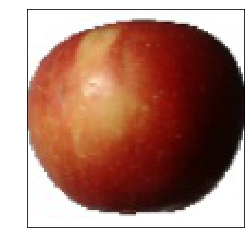

In [95]:
l = torch.utils.data.DataLoader(ImageFolderWithPaths(root=train_path, transform=transformer), 
                                batch_size=2, sampler=CustomSampler([0,100]))
x, y,t = next(iter(l))
plt.imshow(np.transpose(x[0], (1,2,0)))

In [101]:
torch.tensor([0]).index(0)

AttributeError: 'Tensor' object has no attribute 'index'

In [112]:
def show_images(dataset, total=10, n_per_class=None, classes=None, layout=None, shuffle=True):
    if classes is not None and len(classes) > 0:
        if n_per_class:
            if isinstance(classes, int):
                assert isinstance(n_per_class, int), TypeError
                target_idx = (torch.tensor(dataset.targets)==classes).nonzero()[0]
                sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)
            elif isinstance(classes, str):
                assert isinstance(n_per_class, int), TypeError
                target_idx = (torch.tensor(dataset.targets)==dataset.class_to_idx[classes]).nonzero()
                sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)
            else:
                assert hasattr(classes, '__iter__'), TypeError    # Ensure classes is an iterable
                assert not(isinstance(classes, dict)), "Cannot handle dict Type for classes"
                # Create the indices array
                if isinstance(classes[0], np.int32) or isinstance(classes[0], np.int64) or isinstance(classes[0], int):
                    for c in classes:
                        (dataset.targets == c).nonzero()[0]
                    target_idx = np.isin(dataset.targets, classes).nonzero()[0]    # .nonzero() returns a tuple of numpy array of indices where not zero
                elif isinstance(classes[0], str) or isinstance(classes[0], np.object):
                    target_idx = np.isin(dataset.targets, np.isin(labels_mapping, classes).nonzero()[0]).nonzero()[0]
                else:
                    raise TypeError
                sampler = CustomSampler(target_idx)
        else:
            if isinstance(classes, int):
                target_idx = (torch.tensor(dataset.targets)==classes).nonzero()
                sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)
            elif isinstance(classes, str):
                target_idx = (torch.tensor(dataset.targets)==dataset.class_to_idx[classes]).nonzero()
                sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)
            else:
                assert hasattr(classes, '__iter__'), TypeError    # Ensure classes is an iterable
                assert not(isinstance(classes, dict)), "Cannot handle dict Type for classes"
                # Create the indices array
                if isinstance(classes[0], np.int32) or isinstance(classes[0], np.int64) or isinstance(classes[0], int):
                    target_idx = np.isin(dataset.targets, classes).nonzero()[0]    # .nonzero() returns a tuple of numpy array of indices where not zero
                elif isinstance(classes[0], str) or isinstance(classes[0], np.object):
                    target_idx = np.isin(dataset.targets, np.isin(labels_mapping, classes).nonzero()[0]).nonzero()[0]
                else:
                    raise TypeError
                #sampler = torch.utils.data.sampler.SequentialSampler(target_idx)
                sampler = CustomSampler(target_idx)
        # shuffle and sampler are mutually exclusive
        shuffle = False
    else:
        if isinstance(n_per_class, int):
            # Get n_per_class images for each class
            total = n_per_class * len(dataset.classes)
            target_idx = np.zeros(total)
            for c in dataset.class_to_idx.values():
                if shuffle:
                    target_idx[c*n_per_class:(c+1)*n_per_class] = np.random.choice((dataset.targets==c).nonzero()[0], size=n_per_class, replacement=False)
                else:
                    target_idx[c*n_per_class:(c+1)*n_per_class] = (dataset.targets==c).nonzero()[0][:n_per_class]
            sampler = CustomSampler(target_idx)
        else:
            print("n_per_class can only be an integer when classes is None")
            raise TypeError
        sampler = None
    loader = torch.utils.data.DataLoader(dataset, batch_size=total, shuffle=shuffle, sampler=sampler)
    imgs, labels = next(iter(loader))   # imgs.shape = (Batch_size, Channel, Width, Height)
    if layout:
        rows, cols = layout
        if total > rows*cols:
            warnings.warn("""Number of images (total=%d) is greater than total number of elements (%d) in layout (%d, %d).
            Will show only first (%d) images""" % (total, rows*cols, rows, cols, rows*cols))
            total = rows*cols
    else:
        # Default layout with 10 images per row
        cols = 10
        rows = total//cols+(1 if total%cols else 0)
    fig, ax = plt.subplots(rows, cols, figsize=(cols*rows, 3*rows))
    for i in range(total):
        ax[i//cols, i%cols].imshow(np.transpose(imgs[i], (1,2,0)))
        ax[i//cols, i%cols].set_title(labels_mapping.loc[int(labels[i])], color='white')
        ax[i//cols, i%cols].set_xticks([])
        ax[i//cols, i%cols].set_yticks([])
    # Delete remaining axes if exist
    for j in range(i+1, rows*cols):
        fig.delaxes(ax[j//cols,j%cols])
    plt.show()

In [113]:
# Testing function
show_images(train_dataset, n_per_class=[1], classes=None)

n_per_class can only be an integer when classes is None


TypeError: 

In [35]:
transformer = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transformer)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transformer)
labels_mapping = pd.Series(train_dataset.classes)
#transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)

TRAIN_DATASET


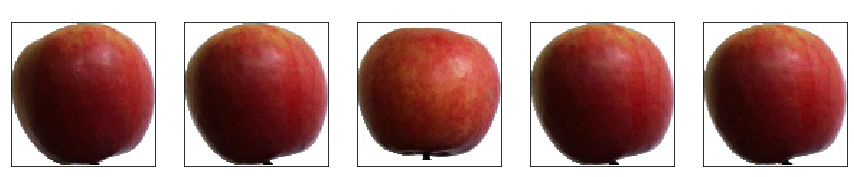

TEST DATASET


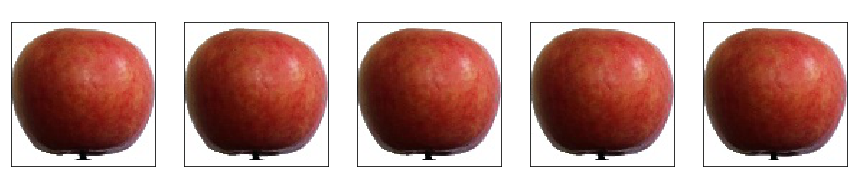

In [108]:
print("TRAIN_DATASET")
show_images(train_dataset, 5, classes=np.array([1, 2]), layout=(3,5), shuffle=True)
print("TEST DATASET")
show_images(test_dataset, 5, classes=np.array([1, 2]), layout=(3,5), shuffle=True)

## Varieties of fruit

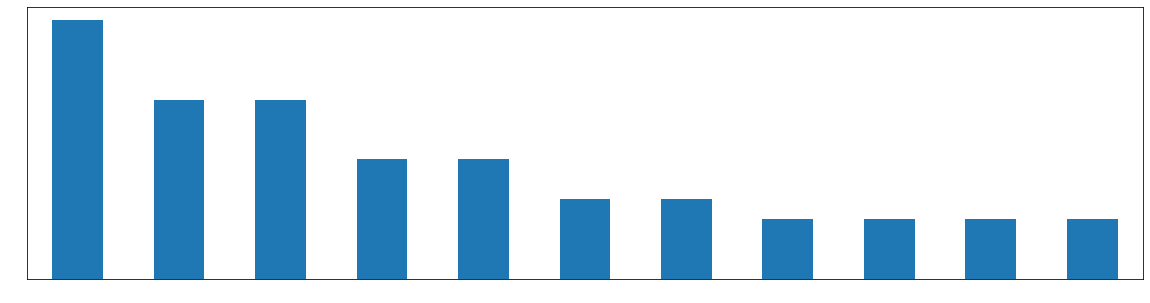

In [203]:
base_fruit = labels_mapping.str.split(' ').str[0]
varieties = base_fruit.value_counts()
varieties[varieties > 2].plot(kind="bar", figsize=(20,5), rot=0, yticks=range(0, max(varieties)+1))

### Show all varieties of Apple

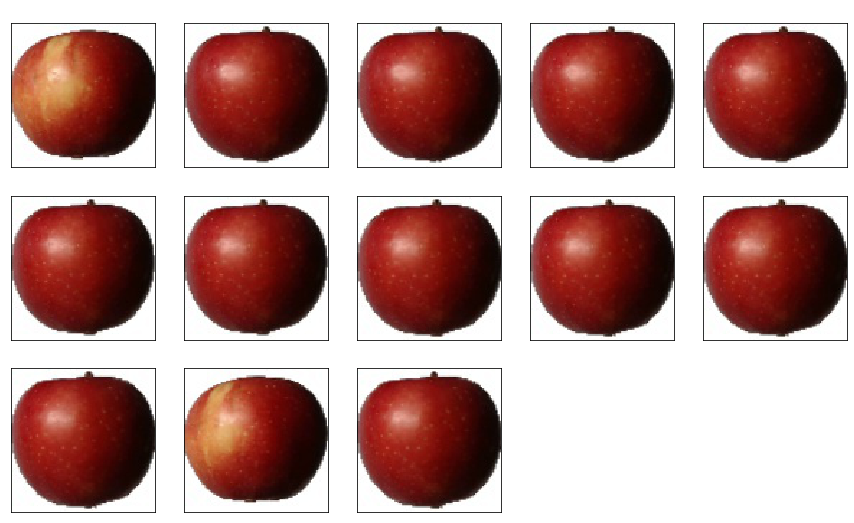

In [274]:
show_images(train_dataset, 13, layout=(3, 5), classes=labels_mapping[base_fruit==varieties.index[0]].values)

### Show all varieties of Tomato

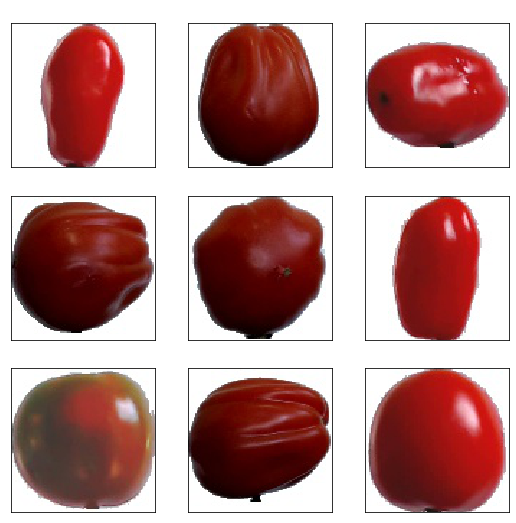

In [272]:
show_images(train_dataset, 9, layout=(3, 3), classes=labels_mapping[base_fruit==varieties.index[1]].values)

In [270]:
labels_mapping[base_fruit==varieties.index[1]]

120              Tomato 1
121              Tomato 2
122              Tomato 3
123              Tomato 4
124     Tomato Cherry Red
125          Tomato Heart
126         Tomato Maroon
127         Tomato Yellow
128    Tomato not Ripened
dtype: object

## Check for duplicates

In [18]:
print("No of Training Fruit categories = %d (Unique = %d # Checking for duplicates)" % (len(train_labels), len(set(train_labels))))
print("No of Test Fruit categories = %d (Unique = %d # Checking for duplicates)" % (len(test_labels), len(set(test_labels))))

No of Training Fruit categories = 131 (Unique = 131 # Checking for duplicates)
No of Test Fruit categories = 131 (Unique = 131 # Checking for duplicates)


## Check for labels consistency

In [25]:
train_counts = dict((label, len(glob(os.path.join(train_path, label, "*")))) for label in train_labels)
test_counts = dict((label, len(glob(os.path.join(test_path, label, "*")))) for label in test_labels)
print("All labels of test data are present in training data - %s" % (set(train_counts) == set(test_counts)))

All labels of test data are present in training data - True


## Visualize distribution of fruit categories

In [34]:
df_counts = pd.DataFrame([train_counts.values(), test_counts.values()], index=["Training", "Test"], columns=train_counts.keys()).T
df_counts

Training  Test
Apple Braeburn           492   164
Apple Crimson Snow       444   148
Apple Golden 1           480   160
Apple Golden 2           492   164
Apple Golden 3           481   161
...                      ...   ...
Tomato Maroon            367   127
Tomato not Ripened       474   158
Tomato Yellow            459   153
Walnut                   735   249
Watermelon               475   157

[131 rows x 2 columns]

### Total images

Training    67692
Test        22688
dtype: int64


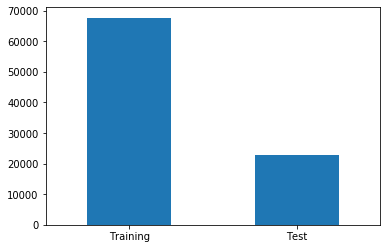

In [75]:
print(df_counts.sum())
df_counts.sum().plot(kind="bar", rot=0);

In [68]:
df_counts.sum().sum()

90380

### Plot the distribution of images per fruit category

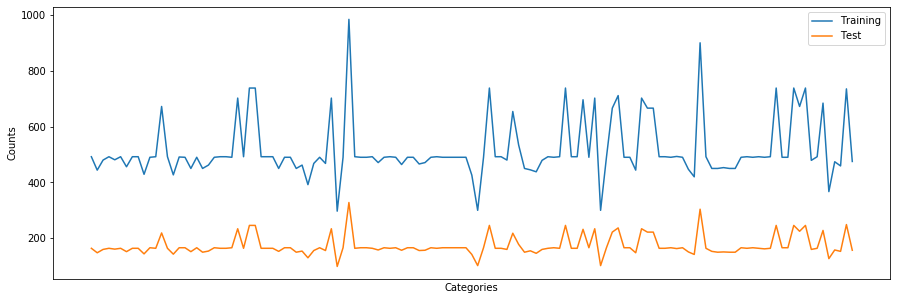

In [56]:
ax = df_counts.plot(figsize=(15,5), xticks=[])
ax.set_xlabel("Categories"); ax.set_ylabel("Counts");

In [62]:
round((df_counts["Training"]/df_counts["Test"]).mean())

3.0

From the plot, we can see that the test images and training images are in proportion, which suggests that the initial dataset was combined and for users convenience, it has been split by a ratio of <b>Train:Test :: 3:1<b>

### Top 5 and Bottom 5 categories according to number of images
Might require resampling to avoid ML model bias

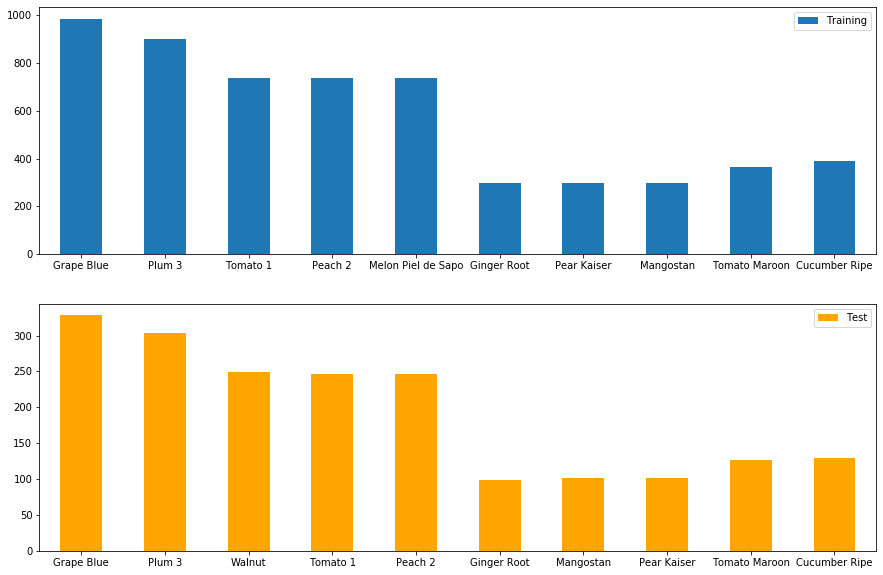

In [112]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
df_counts["Training"].sort_values(ascending=False) \
.iloc[list(range(5))+list(range(-1,-6,-1))].plot(kind="bar", ax=ax1, rot=0, legend=True)
df_counts["Test"].sort_values(ascending=False) \
.iloc[list(range(5))+list(range(-1,-6,-1))].plot(kind="bar", color="orange", ax=ax2, rot=0, legend=True);

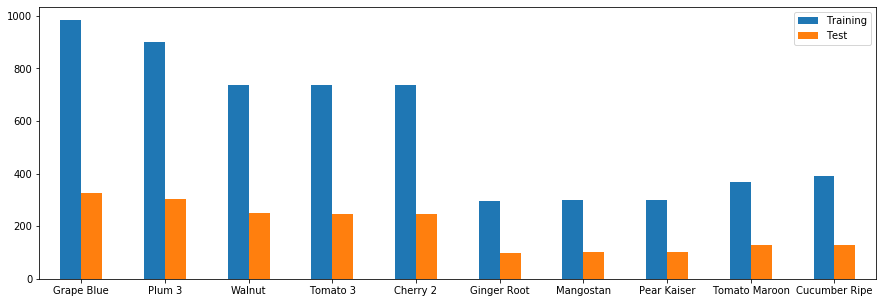

In [114]:
df_counts.sort_values("Test", ascending=False) \
.iloc[list(range(5))+list(range(-1,-6,-1))].plot(kind="bar", rot=0, figsize=(15,5));